In [1]:
from functional import *
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
def generate_linear(n= 100):
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append((pt[0], pt[1]))
        distance = (pt[0] - pt[1]) / 1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1)

def generate_XOR_easy():
    inputs = []
    labels = []
    for i in range(11):
        inputs.append([0.1 * i , 0.1 * i])
        labels.append(0)

        if 0.1 * i == 0.5:
            continue
            
        inputs.append([0.1 * i, 1 - 0.1 * i])
        labels.append(1)

    return np.array(inputs), np.array(labels).reshape(21, 1)

In [3]:
# non-linear model
class Model:

    def __init__(self, optimizer= "SGD", activation= "sigmoid", hidden_unit= 10, lr= 1e-1):

        self.optimizer = optimizer
        
        self.lr = lr

        # hidden layer1
        self.h1 = Linear(2, hidden_unit, bias= False)
        # hidden layer2
        self.h2 = Linear(hidden_unit, hidden_unit, bias= False)
        # output layer
        self.output = Linear(hidden_unit, 1, bias= False)

        if activation == "sigmoid":
            self.activation  = sigmoid
            self.de_activation = derivative_sigmoid
        elif activation == "ReLU":
            self.activation  = ReLU
            self.de_activation = derivative_ReLU
        elif activation == "LeakyReLU":
            self.activation  = LeakyReLU
            self.de_activation = derivative_LeakyReLU
        elif activation == "tanh":
            self.activation  = tanh
            self.de_activation = derivative_tanh
        elif activation == "without":
            self.activation = without
            self.de_activation = derivative_without
        
        if self.optimizer == "momentum":
            self.v_w1 = 0
            self.v_w2 = 0
            self.v_w3 = 0
            self.decay = 0.9
        elif self.optimizer == "AdaGrad":
            self.total_w1 = 0
            self.total_w2 = 0
            self.total_w3 = 0
        


    def __call__(self, x):
        return self.__forward__(x) 

    def __forward__(self, input):        
    
        x = self.h1(input)
        x = self.activation(x)
        x = self.h2(x)
        x = self.activation(x)
        x = self.output(x)        
        return x

    def __backward__(self, y, y_pred):

        """ 
        a1 * w1 = z1, 
        activation(z1) = a2
        a2 * w2 = z2
        activation(z2) = a3
        a3 * w3 = z3 (y_pred) <---> y (ground_truth)
        """

        # de(L) / de(y_pred)
        grad_y_pred = 2 * (y_pred - y) / y_pred.shape[0]
        # de(y_pred) / de(a3) * grad_y_pred
        grad_a3 = np.matmul(grad_y_pred, self.output.weight)
        # de(a3) / de(z2) * grad_a3
        grad_z2 = grad_a3 * self.de_activation(self.output.a)
        # de(z2) / de(a2) * grad_z2
        grad_a2 = np.matmul(grad_z2, self.h2.weight)
        # de(a2) / de(z1) * grad_a2 
        grad_z1 = grad_a2 * self.de_activation(self.h2.a)
        
        # de(L) / de(w1) = de(L)/de(pred_y) * de(y_pred)/de(a3) * de(a3)/de(z2) * de(z2)/de(a2) * de(a2)/de(z1) * de(z1)/de(w1)
        # de(z1) / de(w1) * grad_z1
        self.grad_w1 = np.matmul(grad_z1.T, self.h1.a)
        # de(L) / de(w2) = de(L)/de(pred_y) * de(pred_y)/de(a3) * de(a3)/de(z2) * de(z2)/de(w2)
        # de(z2) / de(w2) * grad_z2
        self.grad_w2 = np.matmul(grad_z2.T, self.h2.a)
        # de(L) / de(w3) = de(L)/de(pred_y) * de(pred_y)/de(w3)
        # de(pred_y) / de(w3) * grad_y_pred
        self.grad_w3 = np.matmul(grad_y_pred.T, self.output.a)

    def __update__(self):
        
        # Stochastic Gradient Decent(SGD)
        if self.optimizer == "SGD":
            self.h1.weight -= self.lr * self.grad_w1
            self.h2.weight -= self.lr * self.grad_w2
            self.output.weight -= self.lr * self.grad_w3
        # when the direction change, speed (v) become slow.
        elif self.optimizer == "momentum":
            self.v_w1 = self.decay * self.v_w1 + self.lr * self.grad_w1
            self.h1.weight -= self.v_w1
            self.v_w2 = self.decay * self.v_w2 + self.lr * self.grad_w2
            self.h2.weight -= self.v_w2
            self.v_w3 = self.decay * self.v_w3 + self.lr * self.grad_w3
            self.output.weight -= self.v_w3
        # when the total_grad is small, learning rate is large.
        elif self.optimizer == "AdaGrad":
            self.total_w1 += (self.grad_w1) ** 2
            self.h1.weight -= self.grad_w1 * self.lr / (np.sqrt(self.total_w1 + 1e-8))
            self.total_w2 += (self.grad_w2) ** 2
            self.h2.weight -= self.grad_w2 * self.lr / (np.sqrt(self.total_w2 + 1e-8))
            self.total_w3 += (self.grad_w3) ** 2
            self.output.weight -= self.grad_w3 * self.lr / (np.sqrt(self.total_w3 + 1e-8))

    def save_weight(self):
        print("Save best model")
        self.save_h1_weight = self.h1.weight
        self.save_h2_weight = self.h2.weight
        self.save_output_weight = self.output.weight

    def load_weight(self):
        print("Load best model")
        self.h1.weight = self.save_h1_weight
        self.h2.weight = self.save_h2_weight
        self.output.weight = self.save_output_weight
        

In [4]:
def draw_history(history):
    
    plt.figure()
    plt.plot(history["loss"], label = f'train_loss')
    plt.plot(history["acc"], label = f'train_acc')
    plt.xlabel('Epoch')
    plt.legend()

In [5]:
def train(model, epochs, x, y):
    
    history = {"loss":[], "acc":[]}
    best_acc = None

    for epoch in range(epochs):
        # Prediction
        y_pred = model(x)
        # MSE(mean square error) loss    
        loss = ((y - y_pred) ** 2).mean()
        acc = (np.where(y_pred >= 0.5, 1, 0) == y).mean()

        history["loss"].append(loss)
        history["acc"].append(acc)
        if epoch % 5000 == 0:
            print(f"[{epoch} / {epochs}] Loss: {loss}, Acc: {acc}")
        # Save best model
        if((best_acc == None) or (acc > best_acc)):
            best_acc = acc
            model.save_weight()

        # Backward
        model.__backward__(y, y_pred)
        # Update weight
        model.__update__()
    
    draw_history(history)

    return model

In [6]:
# x, y = generate_linear()
# test_x, test_y = generate_linear()
x, y = generate_XOR_easy()
test_x, test_y = generate_XOR_easy()

In [7]:
# HyperParameter
EPOCHS = 100000
LR = 0.1

In [8]:
model = Model(optimizer= "SGD", activation= "sigmoid", hidden_unit= 10, lr= LR)
model = train(model, EPOCHS, x, y)

TypeError: Model.__init__() got an unexpected keyword argument 'epochs'

In [ ]:
def show_result(x, y, pred_y):
    plt.subplot(1, 2, 1)
    plt.title("Ground truth", fontsize= 18)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0], x[i][1], "ro")
        else:
            plt.plot(x[i][0], x[i][1], "bo")

    plt.subplot(1, 2, 2)
    plt.title("Predict result", fontsize= 18)
    for i in range(x.shape[0]):
        if pred_y[i] == 0:
            plt.plot(x[i][0], x[i][1], "ro")
        else:
            plt.plot(x[i][0], x[i][1], "bo")
    
    plt.show()

In [ ]:
def test(model, x, y):
    y_pred = model(x)
    loss = ((y_pred - y) ** 2).mean()

    for i, (y_prediction, y_true) in enumerate(zip(y_pred, y)):
        print("Iter{:3} |  Ground Truth: {:.1f} | Prediction: {:.5f} |".format(i, y_true[0], y_prediction[0]))
    y_pred = np.where(y_pred >= 0.5, 1, 0)
    acc = (y_pred == y).mean()
    print("loss: {:.8f} accuracy: {:.2%}".format(loss, acc))
    show_result(x, y, y_pred)

Load best model
Iter  0 |  Ground Truth: 0.0 | Prediction: 0.00000 |
Iter  1 |  Ground Truth: 1.0 | Prediction: 1.00000 |
Iter  2 |  Ground Truth: 0.0 | Prediction: 0.00000 |
Iter  3 |  Ground Truth: 1.0 | Prediction: 1.00000 |
Iter  4 |  Ground Truth: 0.0 | Prediction: 0.00000 |
Iter  5 |  Ground Truth: 1.0 | Prediction: 1.00000 |
Iter  6 |  Ground Truth: 0.0 | Prediction: 0.00000 |
Iter  7 |  Ground Truth: 1.0 | Prediction: 1.00000 |
Iter  8 |  Ground Truth: 0.0 | Prediction: 0.00000 |
Iter  9 |  Ground Truth: 1.0 | Prediction: 1.00000 |
Iter 10 |  Ground Truth: 0.0 | Prediction: 0.00000 |
Iter 11 |  Ground Truth: 0.0 | Prediction: 0.00000 |
Iter 12 |  Ground Truth: 1.0 | Prediction: 1.00000 |
Iter 13 |  Ground Truth: 0.0 | Prediction: 0.00000 |
Iter 14 |  Ground Truth: 1.0 | Prediction: 1.00000 |
Iter 15 |  Ground Truth: 0.0 | Prediction: 0.00000 |
Iter 16 |  Ground Truth: 1.0 | Prediction: 1.00000 |
Iter 17 |  Ground Truth: 0.0 | Prediction: 0.00000 |
Iter 18 |  Ground Truth: 1.0 |

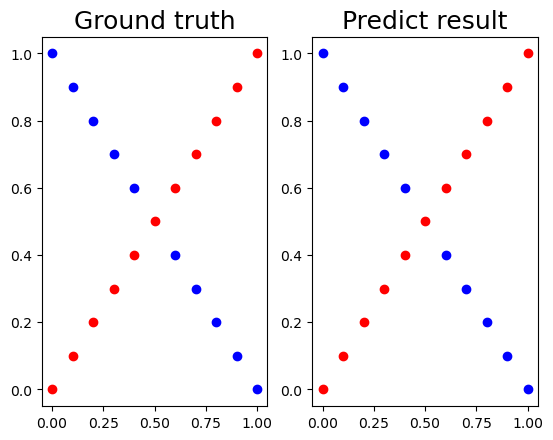

In [ ]:
model.load_weight()
test(model, test_x, test_y)